In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
# noinspection PyUnresolvedReferences
from tensorflow.keras.models import Sequential
# noinspection PyUnresolvedReferences
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
# noinspection PyUnresolvedReferences
from tensorflow.keras.utils import to_categorical

# Defining file path
ecg_folder = "../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised"
attributes_file = "../../../../Datasets/12-lead electrocardiogram database/AttributesDictionary.xlsx"
diagnostics_file = "../../../../Datasets/12-lead electrocardiogram database/Diagnostics.xlsx"
rhythm_names_file = "../../../../Datasets/12-lead electrocardiogram database/RhythmNames.xlsx"

# Checking for missing files and stuff
for file_path in [attributes_file, diagnostics_file, rhythm_names_file]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Required file not found: {file_path}")

# Loading metadata
attributes_df = pd.read_excel(attributes_file)
diagnostics_df = pd.read_excel(diagnostics_file)
rhythm_names_df = pd.read_excel(rhythm_names_file)

# Removing trailing spaces in acronym columns for accurate matching
rhythm_names_df['Acronym Name'] = rhythm_names_df['Acronym Name'].str.strip()

# Creating sets of valid acronyms for rhythm
valid_rhythms = set(rhythm_names_df['Acronym Name'])
print(valid_rhythms)

2024-11-25 08:44:19.496836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 08:44:19.507994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 08:44:19.511496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 08:44:19.520377: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 08:44:20.092110: W tensorflow/compiler/tf2

{'ST', 'SI', 'AT', 'SVT', 'AVRT', 'SAAWR', 'AF', 'SB', 'AVNRT', 'AFIB', 'SR'}


In [2]:
# Based from here <https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection>
class PanTompkinsQRS:
    def __init__(self, sampling_rate: int = 500):
        self.fs = sampling_rate

    def bandpass_filter(self, data: np.ndarray) -> np.ndarray:
        """
        Apply bandpass filter (5-15 Hz) to remove noise
        """
        lowcut = 5.0
        highcut = 15.0
        nyquist = self.fs * 0.5
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(2, [low, high], btype='band')
        return signal.filtfilt(b, a, data)

    @staticmethod
    def derivative(data: np.ndarray) -> np.ndarray:
        """
        Apply derivative filter to emphasize QRS slopes
        """
        return np.gradient(data)

    @staticmethod
    def squaring(data: np.ndarray) -> np.ndarray:
        """
        Square the signal to make all points positive and emphasize high frequencies
        """
        return np.power(data, 2)

    @staticmethod
    def moving_window_integration(data: np.ndarray, window_size: int = 30) -> np.ndarray:
        """
        Apply moving window integration
        """
        window = np.ones(window_size) / window_size
        return np.convolve(data, window, mode='same')

    def detect_qrs(self, data: np.ndarray) -> Tuple[List[int], np.ndarray]:
        """
        Detect QRS complexes in the ECG signal
        Returns: peaks locations and processed signal
        """
        # Apply bandpass filter
        filtered = self.bandpass_filter(data)

        # Apply derivative
        derivative = self.derivative(filtered)

        # Square the signal
        squared = self.squaring(derivative)

        # Moving window integration
        integrated = self.moving_window_integration(squared)

        # Find peaks
        distance = int(0.2 * self.fs)  # Minimum distance between peaks (200ms)
        peaks, _ = signal.find_peaks(integrated, distance=distance)

        return peaks, integrated


def load_and_process_ecg(file_path: str, lead_number: int = 0) -> np.ndarray:
    """
    Load ECG data from the Chapman dataset and process specified lead
    """
    try:
        # Load the data
        data = pd.read_csv(file_path, skiprows=1, header=None).values
        # Extract specified lead
        lead_data = data[:, lead_number]
        return lead_data
    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        return None


def analyze_ecg_file(file_path: str, lead_number: int = 0) -> dict:
    """
    Analyze a single ECG file and return metrics
    """
    # Load and process the ECG data
    ecg_data = load_and_process_ecg(file_path, lead_number)
    if ecg_data is None:
        print(file_path + " is empty")
        return None

    # Initialize Pan-Tompkins QRS detector
    qrs_detector = PanTompkinsQRS()

    # Detect QRS complexes
    peaks, processed_signal = qrs_detector.detect_qrs(ecg_data)

    # Calculate basic heart rate metrics
    if len(peaks) > 1:
        # Calculate RR intervals in seconds
        rr_intervals = np.diff(peaks) / qrs_detector.fs

        # Calculate heart rate in BPM
        heart_rate = 60 / np.mean(rr_intervals)

        # Calculate heart rate variability (standard deviation of RR intervals)
        hrv = np.std(rr_intervals) * 1000  # in milliseconds

        return {
            'num_beats': len(peaks),
            'heart_rate': heart_rate,
            'hrv': hrv,
            'peaks': peaks,
            'processed_signal': processed_signal,
            'raw_signal': ecg_data
        }

    print("Could not find peaks for ", file_path)

    return None


# Example usage with your dataset structure
def process_chapman_dataset(ecg_folder: str, diagnostics_df: pd.DataFrame):
    """
    Process all ECG files in the Chapman dataset
    """
    results = []

    for filename in os.listdir(ecg_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(ecg_folder, filename)

            # Get the record ID from filename
            record_id = filename.split('.')[0]

            analysis = analyze_ecg_file(file_path, lead_number=1)

            if analysis:
                # Get diagnostic information
                diagnostic_info = diagnostics_df[diagnostics_df['FileName'] == record_id]

                result = {
                    'record_id': record_id,
                    'heart_rate': analysis['heart_rate'],
                    'hrv': analysis['hrv'],
                    'num_beats': analysis['num_beats']
                }

                # Add diagnostic information if available
                if not diagnostic_info.empty:
                    result['rhythm'] = diagnostic_info['Rhythm'].iloc[0]

                results.append(result)

    return pd.DataFrame(results)


def plot_ecg_analysis(ecg_data: dict, title: str = "ECG Analysis"):
    """
    Visualize ECG data with detected QRS complexes
    """
    plt.figure(figsize=(15, 10))

    # Plot raw signal
    plt.subplot(2, 1, 1)
    plt.plot(ecg_data['raw_signal'])
    plt.scatter(ecg_data['peaks'], ecg_data['raw_signal'][ecg_data['peaks']],
                color='red', label='QRS Complexes')
    plt.title(f"{title} - Raw Signal")
    plt.legend()

    # Plot processed signal
    plt.subplot(2, 1, 2)
    plt.plot(ecg_data['processed_signal'])
    plt.scatter(ecg_data['peaks'], ecg_data['processed_signal'][ecg_data['peaks']],
                color='red', label='QRS Complexes')
    plt.title("Processed Signal")
    plt.legend()

    plt.tight_layout()
    plt.show()

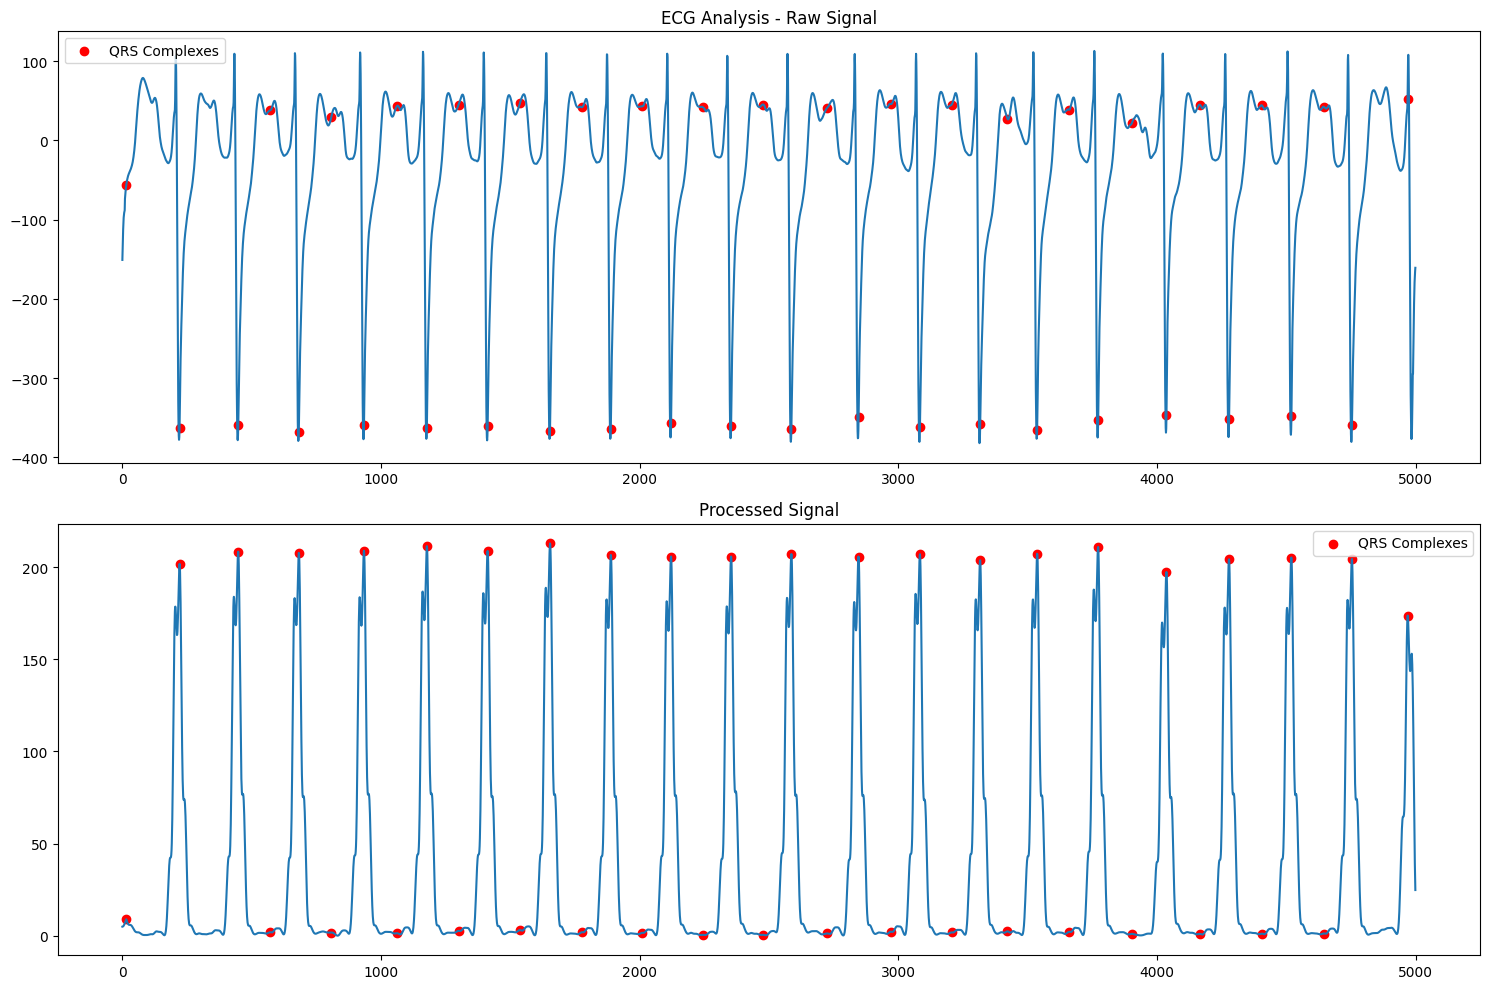

Could not find peaks for  ../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised/MUSE_20181222_204128_13000.csv
Could not find peaks for  ../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised/MUSE_20181222_204248_77000.csv
Could not find peaks for  ../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised/MUSE_20181222_204146_34000.csv
Could not find peaks for  ../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised/MUSE_20181222_204303_61000.csv
Could not find peaks for  ../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised/MUSE_20181222_204236_34000.csv
Could not find peaks for  ../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised/MUSE_20181222_204240_84000.csv
Could not find peaks for  ../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised/MUSE_20181222_204156_45000.csv
Could not find peaks for  ../../../../Datasets/12-lead electrocardiogram database/ECGDataDenoised

In [3]:
processor = PanTompkinsQRS()

# Process a single file
file_path = os.path.join(ecg_folder, "MUSE_20180111_155115_19000.csv")
analysis = analyze_ecg_file(file_path)

# Visualize results
if analysis:
    plot_ecg_analysis(analysis, title="ECG Analysis")

# Process entire dataset
results_df = process_chapman_dataset(ecg_folder, diagnostics_df)
print(results_df.head())

In [4]:
results_df

,record_id,heart_rate,hrv,num_beats,rhythm
0,MUSE_20180712_153346_94000,244.100895,78.199488,41,AF
1,MUSE_20180712_155025_88000,214.504597,70.906204,36,AF
2,MUSE_20180118_133731_39000,178.754880,64.820322,30,SB
3,MUSE_20180113_123833_74000,220.228385,57.073269,37,SB
4,MUSE_20180210_122045_58000,218.181818,46.648806,37,SR
...,...,...,...,...,...
10601,MUSE_20180112_133230_46000,217.785844,63.842471,37,AFIB
10602,MUSE_20180115_123926_81000,190.456686,51.262439,32,AT
10603,MUSE_20180210_121128_24000,233.415233,24.822472,39,SR
10604,MUSE_20180210_123928_58000,197.165742,77.006671,33,SR


In [5]:
results_df.describe()

,heart_rate,hrv,num_beats
count,10606.000000,10606.000000,10606.000000
mean,210.258025,54.461220,35.328210
std,18.182495,19.419047,2.995872
min,128.834356,0.845765,15.000000
25%,201.506208,43.793089,34.000000
50%,211.522965,56.686109,36.000000
75%,220.633299,67.315679,37.000000
max,293.518141,125.170007,49.000000


In [6]:

def group_rhythm_labels(results_df):
    """
    Group rhythm labels into 4 main classes:
    - AFIB (AFIB, AF)
    - GSVT (SVT, AT, SAAWR, ST, AVNRT, AVRT)
    - SB (SB)
    - SR (SR, SA)
    """
    # Create a mapping dictionary
    rhythm_mapping = {
        'AFIB': 'AFIB',
        'AF': 'AFIB',
        'SVT': 'GSVT',
        'AT': 'GSVT',
        'SAAWR': 'GSVT',
        'ST': 'GSVT',
        'AVNRT': 'GSVT',
        'AVRT': 'GSVT',
        'SB': 'SB',
        'SR': 'SR',
        'SA': 'SR'
    }

    # Apply mapping to rhythm column
    results_df['rhythm_grouped'] = results_df['rhythm'].map(rhythm_mapping)

    # Remove rows where rhythm_grouped is NaN (rhythms not in our mapping)
    results_df = results_df.dropna(subset=['rhythm_grouped'])

    # Print distribution of grouped rhythms
    print("\nDistribution of grouped rhythms:")
    print(results_df['rhythm_grouped'].value_counts())

    return results_df


def prepare_data(results_df):
    """
    Prepare data for modeling by encoding labels and scaling features
    """
    # First group the rhythm labels
    results_df = group_rhythm_labels(results_df)

    # Drop rows with missing values
    results_df = results_df.dropna(subset=['heart_rate', 'hrv', 'num_beats', 'rhythm_grouped'])

    # Prepare features
    X = results_df[['heart_rate', 'hrv', 'num_beats']].values

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(results_df['rhythm_grouped'])

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, le.classes_


def create_mlp(input_shape, num_classes):
    """
    Create a Multi-Layer Perceptron with adjusted architecture for 4 classes
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def create_cnn(input_shape, num_classes):
    """
    Create a 1D CNN with padding and appropriate architecture for small feature sets
    """
    model = Sequential([
        # Reshape layer to handle the input properly
        tf.keras.layers.Reshape((input_shape, 1), input_shape=(input_shape,)),

        # First Conv1D block with padding
        Conv1D(
            filters=64,
            kernel_size=2,
            activation='relu',
            padding='same',  # Add padding to prevent dimension reduction
            input_shape=(input_shape, 1)
        ),
        MaxPooling1D(pool_size=2, padding='same'),

        # Flatten and Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print model summary to verify the shapes
    model.summary()
    return model


def train_neural_network(model, X_train, X_test, y_train, y_test, class_names, is_cnn=False):
    """
    Train and evaluate a neural network model
    """
    # Convert labels to one-hot encoding
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # For CNN, we don't need to reshape the data anymore since we do it in the model
    # Remove the reshape operation since it's handled in the model

    # Train the model
    history = model.fit(
        X_train, y_train_cat,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
        ]
    )

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_orig = np.argmax(y_test_cat, axis=1)

    # Print classification report
    print(f"\n{'CNN' if is_cnn else 'MLP'} Classification Report:")
    print(classification_report(y_test_orig, y_pred, target_names=class_names))

    return model, history


def train_decision_tree(X_train, X_test, y_train, y_test, class_names):
    """
    Train and evaluate a decision tree classifier
    """
    # Create and train the model
    dt = DecisionTreeClassifier(random_state=42, max_depth=10)  # Added max_depth to prevent overfitting
    dt.fit(X_train, y_train)

    # Make predictions
    y_pred = dt.predict(X_test)

    # Print classification report
    print("\nDecision Tree Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    return dt


def plot_training_history(history, model_name):
    """
    Plot training history for neural networks
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



Distribution of grouped rhythms:
rhythm_grouped
SB      3889
GSVT    2267
AFIB    2225
SR      2225
Name: count, dtype: int64

Decision Tree Classification Report:
              precision    recall  f1-score   support

        AFIB       0.30      0.22      0.26       445
        GSVT       0.63      0.51      0.56       454
          SB       0.48      0.74      0.58       778
          SR       0.40      0.19      0.26       445

    accuracy                           0.47      2122
   macro avg       0.45      0.42      0.42      2122
weighted avg       0.46      0.47      0.44      2122



/home/denuvo-drm/miniconda3/envs/CompositeADLRecognition/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732502709.029010  313581 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732502709.063208  313581 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732502709.

Epoch 1/100


I0000 00:00:1732502709.980970  314180 service.cc:146] XLA service 0x7702d80059c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732502709.980998  314180 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-25 08:45:10.001531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-25 08:45:10.110259: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


156/213 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.4036 - loss: 1.3217

I0000 00:00:1732502711.386941  314180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4118 - loss: 1.3077 - val_accuracy: 0.4867 - val_loss: 1.1739
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.4642 - loss: 1.2024 - val_accuracy: 0.4862 - val_loss: 1.1535
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.4759 - loss: 1.1801 - val_accuracy: 0.4862 - val_loss: 1.1479
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.4652 - loss: 1.1947 - val_accuracy: 0.4973 - val_loss: 1.1397
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.4762 - loss: 1.1763 - val_accuracy: 0.4920 - val_loss: 1.1416
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.4883 - loss: 1.1700 - val_accuracy: 0.4956 - val_loss: 1.1373
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.4727 - loss: 1.1673 - val_accuracy: 0.4903 - val_loss: 1.1366
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.4701 - loss: 1.1715 - val_a

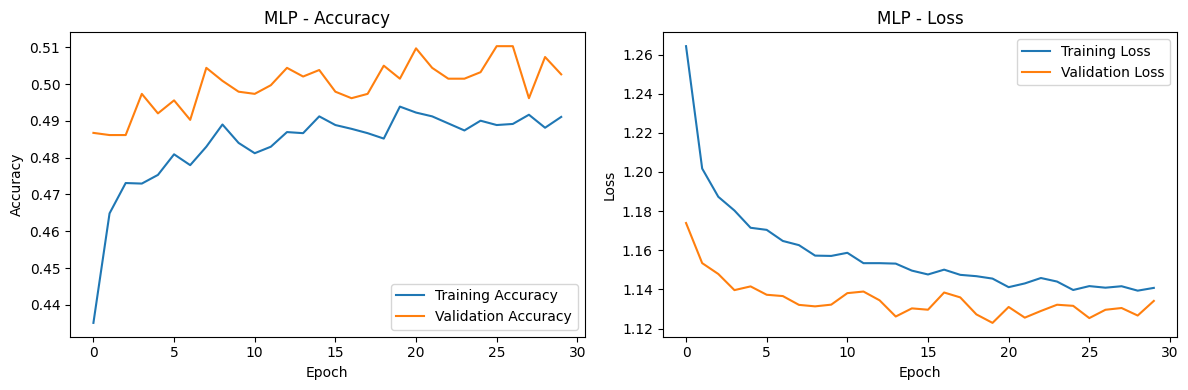

/home/denuvo-drm/miniconda3/envs/CompositeADLRecognition/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/denuvo-drm/miniconda3/envs/CompositeADLRecognition/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,660 (41.64 KB)

 Trainable params: 10,660 (41.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4067 - loss: 1.3185 - val_accuracy: 0.4738 - val_loss: 1.1835
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.4568 - loss: 1.2181 - val_accuracy: 0.4873 - val_loss: 1.1609
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.4747 - loss: 1.1893 - val_accuracy: 0.4956 - val_loss: 1.1517
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.4840 - loss: 1.1803 - val_accuracy: 0.4891 - val_loss: 1.1478
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.4802 - loss: 1.1672 - val_accuracy: 0.4885 - val_loss: 1.1452
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.4790 - loss: 1.1628 - val_accuracy: 0.4962 - val_loss: 1.1432
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.4802 - loss: 1.1655 - val_accuracy: 0.4956 - val_loss: 1.1390
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.4814 - loss: 1.

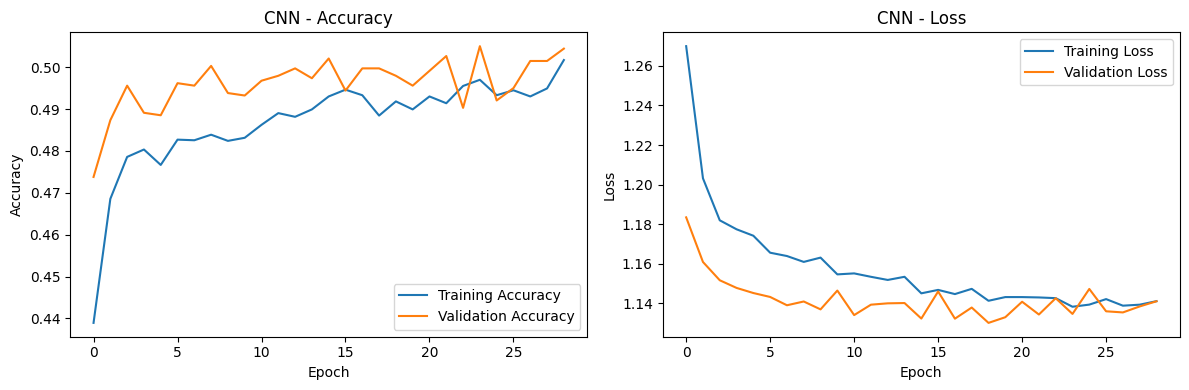

In [7]:
X, y, class_names = prepare_data(results_df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

dt_model = train_decision_tree(X_train, X_test, y_train, y_test, class_names)

mlp_model = create_mlp(X_train.shape[1], len(class_names))
mlp_model, mlp_history = train_neural_network(
    mlp_model, X_train, X_test, y_train, y_test, class_names
)

plot_training_history(mlp_history, 'MLP')

cnn_model = create_cnn(X_train.shape[1], len(class_names))
cnn_model, cnn_history = train_neural_network(
    cnn_model, X_train, X_test, y_train, y_test, class_names, is_cnn=True
)

plot_training_history(cnn_history, 'CNN')